In [3]:
import pandas as pd
import seaborn as sns
from collections import Counter
import category_encoders as ce
from sklearn import preprocessing
from scipy.stats import normaltest
from pandas_profiling import ProfileReport
import numpy as np
# Для анализа отзывов
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Krage\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [1]:
# зафиксировал random seed и версию пакетов, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
!pip freeze > requirements.txt

# Подгрузим данные из соревнования
DATA_DIR = 'data/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') 
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') 

# для корректной обработки признаков объединяем трейн и тест в один датасет (позже разделим)
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями
hotels = df_test.append(df_train, sort=False).reset_index(drop=True) 

In [3]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Анализ данных на профайлере

In [5]:
profile = ProfileReport(hotels, title="Hotels Pandas Profiling Report")
profile

Render HTML: 100%|██████████| 1/1 [00:05<00:00,  5.23s/it]


Имеется 336 дубликатов (удалять нельзя для корректного приема решения на соревновании), есть пропущенные значения в признаках lat и lng

# Обработка данных

In [4]:
# Выделим из адреса отеля страну и город
hotels['country'] = hotels['hotel_address'].apply(lambda country_name: 'United Kingdom' 
                                                  if country_name.endswith('United Kingdom') 
                                                  else country_name.split()[-1].strip()).astype('category')
hotels['city'] = hotels['hotel_address'].apply(lambda city_name: 'London' 
                                               if city_name.endswith('United Kingdom') 
                                               else city_name.split()[-2].strip()).astype('category')


# Проверяем получившиеся значения
display(hotels['country'].value_counts())
display(hotels['city'].value_counts())



United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

Так как в датасете представлены всего 6 городов и соответствующие им 6 стран, можно оставить только один признак (например, страну).

Так как нам известен город отеля, а в признаках широты и долготы имеются пропуски, то и эти признаки можно удалить. Заодно уберем неинформативный признак названия отеля

In [5]:
hotels = hotels.drop(['hotel_address','city','lat','lng','hotel_name'],axis=1)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 15 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                515738 non-null  int64   
 1   review_date                                 515738 non-null  object  
 2   average_score                               515738 non-null  float64 
 3   reviewer_nationality                        515738 non-null  object  
 4   negative_review                             515738 non-null  object  
 5   review_total_negative_word_counts           515738 non-null  int64   
 6   total_number_of_reviews                     515738 non-null  int64   
 7   positive_review                             515738 non-null  object  
 8   review_total_positive_word_counts           515738 non-null  int64   
 9   total_number_of_reviews_reviewer_has_given  515738 non-null

Узнаем месяц отзыва, так как он наиболее важен, а признак даты удалим

In [6]:
hotels['review_month'] = pd.to_datetime(hotels['review_date']).dt.month
hotels = hotels.drop(['review_date'],axis=1)

In [7]:
hotels.head()

additional_number_of_scoring  average_score        reviewer_nationality  \
0                           904            8.1             United Kingdom    
1                           612            8.6                    Belgium    
2                            46            8.3                     Sweden    
3                           241            9.1   United States of America    
4                           834            9.1             United Kingdom    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    
3                                        No Negative   
4                                        No Negative   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   
3                                  0                     1543   
4                                  0                     4687   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   
3   Everything including the nice upgrade The Hot...   
4                    Lovely hotel v welcoming staff    

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   
3                                 27   
4                                  7   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   
3                                           9   
4                                           2   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   
2  [' Business trip ', ' Solo traveler ', ' Twin ...           616 day   
3  [' Leisure trip ', ' Couple ', ' Ambassador Ju...           656 day   
4  [' Business trip ', ' Solo traveler ', ' Class...           444 day   

   sample  reviewer_score      country  review_month  
0       0             0.0        Italy             7  
1       0             0.0  Netherlands            12  
2       0             0.0        Spain            11  
3       0             0.0        Italy            10  
4       0             0.0  Netherlands             5

Проверим корреляцию

<AxesSubplot:>

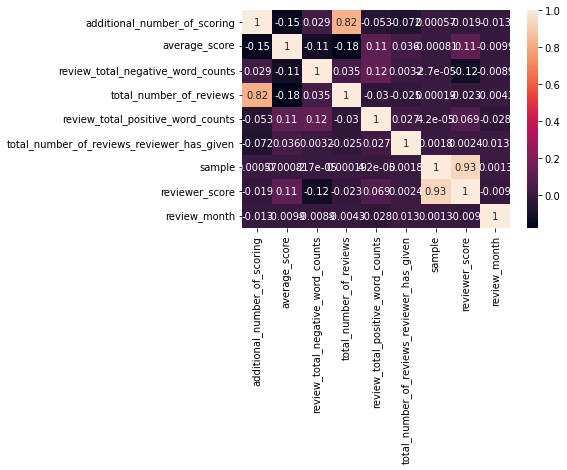

In [9]:
import seaborn as sns
sns.heatmap(hotels.corr(),annot = True)

Признаки total_number_of_reviews и additional_number_of_scoring сильно коррелируют, оставим перый признак

In [10]:
hotels = hotels.drop(['additional_number_of_scoring'],axis=1)

# Обработка тегов

In [11]:
#Из всего набора тегов оставим 11 наиболее популярных в виде бинарных признаков
TAGS_NUMBER = 11
c = Counter()
for tags in hotels['tags'].apply(lambda s: [x.strip() for x in s[1:-1].replace("'",'').split(',')]):
    for tag in tags:
        c[tag] += 1
for tag , _ in c.most_common(TAGS_NUMBER):
    tag_name = tag.lower().replace(' ','_')
    hotels[f"tag_{tag_name}"] = hotels['tags'].apply(lambda tags: bool(tag in tags))        
hotels.drop(['tags'],axis = 1, inplace = True)

In [12]:
hotels.head()

average_score        reviewer_nationality  \
0            8.1             United Kingdom    
1            8.6                    Belgium    
2            8.3                     Sweden    
3            9.1   United States of America    
4            9.1             United Kingdom    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    
3                                        No Negative   
4                                        No Negative   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   
3                                  0                     1543   
4                                  0                     4687   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   
3   Everything including the nice upgrade The Hot...   
4                    Lovely hotel v welcoming staff    

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   
3                                 27   
4                                  7   

   total_number_of_reviews_reviewer_has_given days_since_review  sample  ...  \
0                                           1           13 days       0  ...   
1                                           7           234 day       0  ...   
2                                          15           616 day       0  ...   
3                                           9           656 day       0  ...   
4                                           2           444 day       0  ...   

   tag_submitted_from_a_mobile_device tag_couple  tag_stayed_1_night  \
0                               False       True               False   
1                               False      False                True   
2                                True      False                True   
3                               False       True                True   
4                                True      False               False   

   tag_stayed_2_nights  tag_solo_traveler  tag_stayed_3_nights  \
0                 True              False                False   
1                False              False                False   
2                False               True                False   
3                False              False                False   
4                 True               True                False   

   tag_business_trip  tag_group  tag_family_with_young_children  \
0              False      False                           False   
1              False       True                           False   
2               True      False                           False   
3              False      False                           False   
4               True      False                           False   

   tag_stayed_4_nights  
0                False  
1                False  
2                False  
3                False  
4                False  

[5 rows x 24 columns]

Смотрим на кореляцию

<AxesSubplot:>

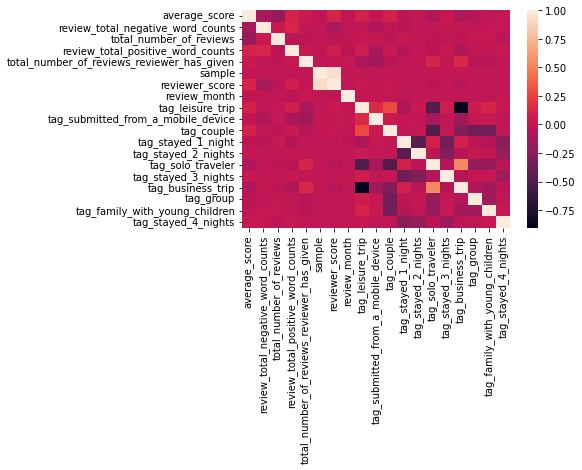

In [13]:
sns.heatmap(hotels.corr())

Теги leisure_trip (поездка на отдых) и business_trip (бизнес поездка) как правило являются взаимоисключающими, и, соответственно, сильно коррелируют. Избавимся от одного признака

In [14]:
hotels = hotels.drop('tag_business_trip', axis=1)

In [15]:
hotels.corr()

average_score  \
average_score                                    1.000000   
review_total_negative_word_counts               -0.112323   
total_number_of_reviews                         -0.179568   
review_total_positive_word_counts                0.106719   
total_number_of_reviews_reviewer_has_given       0.036454   
sample                                          -0.000809   
reviewer_score                                   0.113643   
review_month                                    -0.009889   
tag_leisure_trip                                 0.082307   
tag_submitted_from_a_mobile_device               0.004919   
tag_couple                                       0.094501   
tag_stayed_1_night                              -0.025934   
tag_stayed_2_nights                             -0.002521   
tag_solo_traveler                               -0.082580   
tag_stayed_3_nights                              0.019270   
tag_group                                       -0.028149   
tag_family_with_young_children                  -0.010468   
tag_stayed_4_nights                              0.019884   

                                            review_total_negative_word_counts  \
average_score                                                       -0.112323   
review_total_negative_word_counts                                    1.000000   
total_number_of_reviews                                              0.035124   
review_total_positive_word_counts                                    0.119613   
total_number_of_reviews_reviewer_has_given                           0.003199   
sample                                                              -0.000027   
reviewer_score                                                      -0.120637   
review_month                                                        -0.008877   
tag_leisure_trip                                                    -0.006884   
tag_submitted_from_a_mobile_device                                  -0.082241   
tag_couple                                                          -0.004644   
tag_stayed_1_night                                                  -0.033577   
tag_stayed_2_nights                                                  0.002638   
tag_solo_traveler                                                    0.002698   
tag_stayed_3_nights                                                  0.009044   
tag_group                                                           -0.004542   
tag_family_with_young_children                                       0.011546   
tag_stayed_4_nights                                                  0.013745   

                                            total_number_of_reviews  \
average_score                                             -0.179568   
review_total_negative_word_counts                          0.035124   
total_number_of_reviews                                    1.000000   
review_total_positive_word_counts                         -0.030132   
total_number_of_reviews_reviewer_has_given                -0.024910   
sample                                                     0.000185   
reviewer_score                                            -0.022894   
review_month                                              -0.004345   
tag_leisure_trip                                           0.013729   
tag_submitted_from_a_mobile_device                         0.016524   
tag_couple                                                -0.014228   
tag_stayed_1_night                                         0.027594   
tag_stayed_2_nights                                        0.009864   
tag_solo_traveler                                         -0.017315   
tag_stayed_3_nights                                       -0.010888   
tag_group                                                  0.022847   
tag_family_with_young_children                             0.016928   
tag_stayed_4_nights                                       -0.02159

Создадим признак citizen, который показывает, является ли рецензент гражданином страны, в которой находится отель (это может повлиять на прогнозирование). Удалим уже ненужный признак национальности

In [16]:
# уберем в признаке национальности боковые пробелы для корректности сравнения двух столбцов
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda nation: nation.strip())

# Создаём признак "citizen" с булевыми значениями
hotels['citizen'] = hotels['reviewer_nationality'] == hotels['country']

# Удалим ненужный признак
hotels = hotels.drop(['reviewer_nationality'], axis=1)

In [17]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   average_score                               515738 non-null  float64 
 1   negative_review                             515738 non-null  object  
 2   review_total_negative_word_counts           515738 non-null  int64   
 3   total_number_of_reviews                     515738 non-null  int64   
 4   positive_review                             515738 non-null  object  
 5   review_total_positive_word_counts           515738 non-null  int64   
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64   
 7   days_since_review                           515738 non-null  object  
 8   sample                                      515738 non-null  int64   
 9   reviewer_score                              515738 non-null

# Обработка отзывов

In [18]:
# Удалим "не негативные отзывы" из негативных

no_neg_list = ['absolutely nothing', 'all good', "can't think of anything",
               'everything was great', 'everything was perfect',
               'liked everything', 'n a', 'na', 'nil', 'no', 'no complaints',
               'no negative', 'non', 'none', 'nothing at all', 'nothing really',
               'nothing to complain about', 'nothing to dislike'
              ]

hotels['negative_review'] = hotels['negative_review'].str.lower().str.strip()
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: '' if x in no_neg_list else x)


# Удалим "не положительные отзывы" из положительных

no_pos_list = ['absolutely nothing', 'all was bad', "can't think of anything",
               'everything was awful', 'everything was bad',
               "did't like anything", 'n a', 'na', 'nil', 'no', 'nothing',
               'no positive', 'non', 'none',    'nothing at all', 'nothing really',
               'nothing to like', 'nothing that stands out', 'not very much'
              ]

hotels['positive_review'] = hotels['positive_review'].str.lower().str.strip()
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: '' if x in no_pos_list else x)

In [19]:
sent_analyzer = SentimentIntensityAnalyzer()

#проведем оценку с помощью библиотеки nltk и выделим общую оценку
hotels['negative_review_comp'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
hotels['positive_review_comp'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

#уберем текстовые признаки
hotels = hotels.drop(['negative_review','positive_review'], axis=1)

In [20]:
hotels.head()

average_score  review_total_negative_word_counts  total_number_of_reviews  \
0            8.1                                 52                    16670   
1            8.6                                 10                     5018   
2            8.3                                  3                      351   
3            9.1                                  0                     1543   
4            9.1                                  0                     4687   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   
3                                 27   
4                                  7   

   total_number_of_reviews_reviewer_has_given days_since_review  sample  \
0                                           1           13 days       0   
1                                           7           234 day       0   
2                                          15           616 day       0   
3                                           9           656 day       0   
4                                           2           444 day       0   

   reviewer_score      country  review_month  ...  tag_stayed_1_night  \
0             0.0        Italy             7  ...               False   
1             0.0  Netherlands            12  ...                True   
2             0.0        Spain            11  ...                True   
3             0.0        Italy            10  ...                True   
4             0.0  Netherlands             5  ...               False   

   tag_stayed_2_nights  tag_solo_traveler  tag_stayed_3_nights  tag_group  \
0                 True              False                False      False   
1                False              False                False       True   
2                False               True                False      False   
3                False              False                False      False   
4                 True               True                False      False   

   tag_family_with_young_children  tag_stayed_4_nights  citizen  \
0                           False                False    False   
1                           False                False    False   
2                           False                False    False   
3                           False                False    False   
4                           False                False    False   

   negative_review_comp  positive_review_comp  
0               -0.0554                0.9615  
1               -0.2960                0.0000  
2                0.0000                0.6908  
3                0.0000                0.9153  
4                0.0000                0.7717  

[5 rows x 23 columns]

In [21]:
# уберем слово days в признаке days_since_review
hotels['days_since_review'] = hotels['days_since_review'].str.rstrip(' days').astype(int)

In [22]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   average_score                               515738 non-null  float64 
 1   review_total_negative_word_counts           515738 non-null  int64   
 2   total_number_of_reviews                     515738 non-null  int64   
 3   review_total_positive_word_counts           515738 non-null  int64   
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64   
 5   days_since_review                           515738 non-null  int32   
 6   sample                                      515738 non-null  int64   
 7   reviewer_score                              515738 non-null  float64 
 8   country                                     515738 non-null  category
 9   review_month                                515738 non-null

Таким образом, у нас не осталось признаков с типом object (страны мы чуть позже закодируем)

# Проверка на нормальность

In [23]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

col_names = ['average_score','review_total_negative_word_counts','review_total_positive_word_counts',
             'total_number_of_reviews_reviewer_has_given','total_number_of_reviews','days_since_review']

_, p = normaltest(hotels[col_names])
#normaltest возвращает двустороннюю вероятность для проверки гипотезы

print('p=%.3f' % p[0])

# Интерпретация 

if p[0] > alpha/2:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


# Нормализация данных

In [24]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()
# копируем исходный датасет
df_r = r_scaler.fit_transform(hotels[col_names])

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=col_names)

In [25]:
df_r.head()

average_score  review_total_negative_word_counts  \
0      -0.428571                           2.047619   
1       0.285714                           0.047619   
2      -0.142857                          -0.285714   
3       1.000000                          -0.428571   
4       1.000000                          -0.428571   

   review_total_positive_word_counts  \
0                           3.000000   
1                          -0.647059   
2                          -0.352941   
3                           0.941176   
4                          -0.235294   

   total_number_of_reviews_reviewer_has_given  total_number_of_reviews  \
0                                   -0.285714                 5.928222   
1                                    0.571429                 1.176183   
2                                    1.714286                -0.727162   
3                                    0.857143                -0.241028   
4                                   -0.142857                 1.041191   

   days_since_review  
0          -0.965909  
1          -0.338068  
2           0.747159  
3           0.860795  
4           0.258523

In [26]:
#Заменяем признаки на нормализованные
hotels = hotels.drop(col_names,axis=1)
hotels = pd.concat([hotels,df_r],axis=1)

In [27]:
hotels.head(2)

sample  reviewer_score      country  review_month  tag_leisure_trip  \
0       0             0.0        Italy             7              True   
1       0             0.0  Netherlands            12              True   

   tag_submitted_from_a_mobile_device  tag_couple  tag_stayed_1_night  \
0                               False        True               False   
1                               False       False                True   

   tag_stayed_2_nights  tag_solo_traveler  ...  tag_stayed_4_nights  citizen  \
0                 True              False  ...                False    False   
1                False              False  ...                False    False   

   negative_review_comp  positive_review_comp  average_score  \
0               -0.0554                0.9615      -0.428571   
1               -0.2960                0.0000       0.285714   

   review_total_negative_word_counts  review_total_positive_word_counts  \
0                           2.047619                           3.000000   
1                           0.047619                          -0.647059   

   total_number_of_reviews_reviewer_has_given  total_number_of_reviews  \
0                                   -0.285714                 5.928222   
1                                    0.571429                 1.176183   

   days_since_review  
0          -0.965909  
1          -0.338068  

[2 rows x 23 columns]

# Кодирование признаков

In [28]:
# Закодируем названия городов и стран
hotels = pd.concat([hotels, ce.OneHotEncoder(cols=['country','review_month']).fit_transform(hotels[['country','review_month']]) ], axis=1)
#удалим изначальные признаки из датасета
hotels = hotels.drop(['country','review_month'],axis=1)

In [29]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   sample                                      515738 non-null  int64  
 1   reviewer_score                              515738 non-null  float64
 2   tag_leisure_trip                            515738 non-null  bool   
 3   tag_submitted_from_a_mobile_device          515738 non-null  bool   
 4   tag_couple                                  515738 non-null  bool   
 5   tag_stayed_1_night                          515738 non-null  bool   
 6   tag_stayed_2_nights                         515738 non-null  bool   
 7   tag_solo_traveler                           515738 non-null  bool   
 8   tag_stayed_3_nights                         515738 non-null  bool   
 9   tag_group                                   515738 non-null  bool   
 

Проверим еще раз признаки на сильную кореляцию

In [30]:
hotels.corr()[abs(hotels.corr()) > 0.7]

sample  reviewer_score  \
sample                                      1.000000        0.931753   
reviewer_score                              0.931753        1.000000   
tag_leisure_trip                                 NaN             NaN   
tag_submitted_from_a_mobile_device               NaN             NaN   
tag_couple                                       NaN             NaN   
tag_stayed_1_night                               NaN             NaN   
tag_stayed_2_nights                              NaN             NaN   
tag_solo_traveler                                NaN             NaN   
tag_stayed_3_nights                              NaN             NaN   
tag_group                                        NaN             NaN   
tag_family_with_young_children                   NaN             NaN   
tag_stayed_4_nights                              NaN             NaN   
citizen                                          NaN             NaN   
negative_review_comp                             NaN             NaN   
positive_review_comp                             NaN             NaN   
average_score                                    NaN             NaN   
review_total_negative_word_counts                NaN             NaN   
review_total_positive_word_counts                NaN             NaN   
total_number_of_reviews_reviewer_has_given       NaN             NaN   
total_number_of_reviews                          NaN             NaN   
days_since_review                                NaN             NaN   
country_1                                        NaN             NaN   
country_2                                        NaN             NaN   
country_3                                        NaN             NaN   
country_4                                        NaN             NaN   
country_5                                        NaN             NaN   
country_6                                        NaN             NaN   
review_month_1                                   NaN             NaN   
review_month_2                                   NaN             NaN   
review_month_3                                   NaN             NaN   
review_month_4                                   NaN             NaN   
review_month_5                                   NaN             NaN   
review_month_6                                   NaN             NaN   
review_month_7                                   NaN             NaN   
review_month_8                                   NaN             NaN   
review_month_9                                   NaN             NaN   
review_month_10                                  NaN             NaN   
review_month_11                                  NaN             NaN   
review_month_12                                  NaN             NaN   

                                            tag_leisure_trip  \
sample                                                   NaN   
reviewer_score                                           NaN   
tag_leisure_trip                                         1.0   
tag_submitted_from_a_mobile_device                       NaN   
tag_couple                                               NaN   
tag_stayed_1_night                                       NaN   
tag_stayed_2_nights                                      NaN   
tag_solo_traveler                                        NaN   
tag_stayed_3_nights                                      NaN   
tag_group                                                NaN   
tag_family_with_young_children                           NaN   
tag_stayed_4_nights                                      NaN   
citizen                                                  NaN   
negative_review_comp                                     NaN   
positive_review_comp                                     NaN   
average_score                                            NaN   
review_total_negative_word_counts                        NaN   
review_total_

<AxesSubplot:>

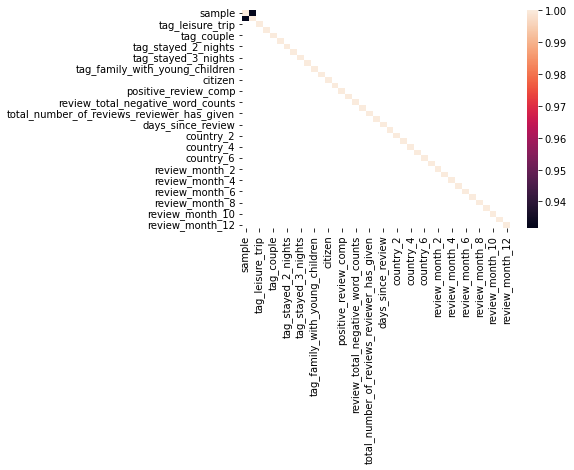

In [31]:
sns.heatmap(hotels.corr()[abs(hotels.corr()) > 0.7])

Сильной связи нет (признак score является служебным и будет удален)

# Обучение модели

In [32]:
# Загружаем инструмент для разделения датасета:
from sklearn.model_selection import train_test_split


# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [33]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 38), (386803, 38), (386803, 37), (309442, 37), (77361, 37))

In [34]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [35]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [36]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


In [37]:
# оцениваем точность прогноза
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred)) 

MAPE: 12.570683854225795


<AxesSubplot:>

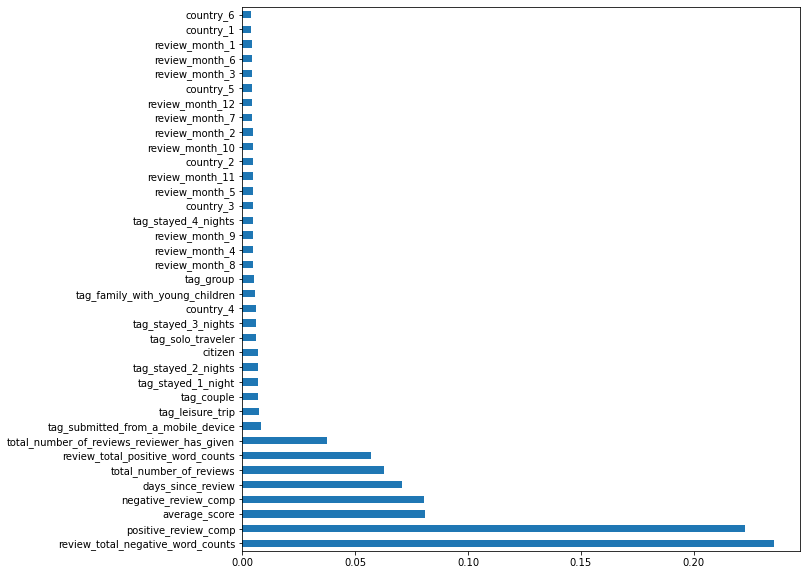

In [38]:
import matplotlib as plt

# выводим самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [39]:
# готовим ответ
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission3.csv', index=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [40]:
pd.read_csv('submission3.csv')

reviewer_score      id
0                8.655  488440
1                7.174  274649
2                8.541  374688
3                9.702  404352
4                9.617  451596
...                ...     ...
128930           8.671  495812
128931           9.340  315577
128932           8.125  511968
128933           9.722  303386
128934           7.078  103157

[128935 rows x 2 columns]